## NFL Points vs Yards per Game clustering

This is a sandbox notebook to test out some sci-kit learn clustering algorithms on NFL scoring data. We want to see if we can separate teams into "tiers" based on plots of their defensive and ofensive points-per-game (PPG) and yards-per-game (YPG). We collected the data by scraping [Pro-Football Reference](https://www.pro-football-reference.com) with our [scraper](https://github.com/andrewbowen19/football-stats-analysis/blob/main/src/scraper.py) script contained in this repo.

#### Some algorithms to try out:
- [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans)
- Affinity Propagation
- DBSCAN

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plotly.express as px
from sklearn.cluster import KMeans


In [27]:
# Would like to run a k-means clustering on PPG-YPG
csv_path = os.path.join("..", "data", "nfl-stats-by-season.csv")
df = pd.read_csv(csv_path)

df.columns = ['Tm', 'W', 'L', 'W-L%', 'PF', 'PA', 'PD', 'MoV', 'SoS', 'SRS',
              'OSRS', 'DSRS', 'Rk', 'G', 'Yds', 'Ply', 'Y/P', 'TO', 'FL', '1stD',
              'Cmp', 'Att', 'Yds_opp', 'Season']

df.head()

,Tm,W,L,W-L%,PF,PA,PD,MoV,SoS,SRS,...,Yds,Ply,Y/P,TO,FL,1stD,Cmp,Att,Yds_opp,Season
0,Buffalo Bills,11,6,0.647,483,289,194,11.4,-1.6,9.8,...,6493.0,1143.0,5.7,22.0,6.0,398.0,415.0,655.0,4637.0,2021
1,New England Patriots,10,7,0.588,462,303,159,9.4,-0.9,8.5,...,6008.0,1052.0,5.7,23.0,10.0,362.0,364.0,535.0,5284.0,2021
2,Miami Dolphins,9,8,0.529,341,373,-32,-1.9,-0.8,-2.7,...,5219.0,1097.0,4.8,26.0,12.0,325.0,404.0,615.0,5738.0,2021
3,New York Jets,4,13,0.235,310,504,-194,-11.4,1.0,-10.4,...,5208.0,1036.0,5.0,27.0,7.0,310.0,357.0,603.0,6760.0,2021
4,Cincinnati Bengals,10,7,0.588,460,376,84,4.9,-1.9,3.1,...,6145.0,1046.0,5.9,21.0,7.0,337.0,384.0,555.0,5964.0,2021


In [28]:
# Calculating YPG and PPG from season totals
df['PPG'] = df['PF'] / df['G']
df['YPG'] = df['Yds'] / df['G']

df['PPG_opp'] = df['PA'] / df['G']
df['YPG_opp'] = df['Yds_opp'] / df['G'] 

df.head()


,Tm,W,L,W-L%,PF,PA,PD,MoV,SoS,SRS,...,FL,1stD,Cmp,Att,Yds_opp,Season,PPG,YPG,PPG_opp,YPG_opp
0,Buffalo Bills,11,6,0.647,483,289,194,11.4,-1.6,9.8,...,6.0,398.0,415.0,655.0,4637.0,2021,28.411765,381.941176,17.000000,272.764706
1,New England Patriots,10,7,0.588,462,303,159,9.4,-0.9,8.5,...,10.0,362.0,364.0,535.0,5284.0,2021,27.176471,353.411765,17.823529,310.823529
2,Miami Dolphins,9,8,0.529,341,373,-32,-1.9,-0.8,-2.7,...,12.0,325.0,404.0,615.0,5738.0,2021,20.058824,307.000000,21.941176,337.529412
3,New York Jets,4,13,0.235,310,504,-194,-11.4,1.0,-10.4,...,7.0,310.0,357.0,603.0,6760.0,2021,18.235294,306.352941,29.647059,397.647059
4,Cincinnati Bengals,10,7,0.588,460,376,84,4.9,-1.9,3.1,...,7.0,337.0,384.0,555.0,5964.0,2021,27.058824,361.470588,22.117647,350.823529


In [29]:
hover_data = ['Tm', 'Season']

In [65]:
# Plotting PPG vs YPG (Offensive)

px.scatter(df, x='YPG', y='PPG', color='Season',  hover_name='Tm', hover_data=['Season'])

In [31]:
# Plotting opponent PPG vs YpG
px.scatter(df, x='YPG_opp', y='PPG_opp', color='Season')

In [67]:
# Let's make these figures a bit more interactive with plotly
def make_scatter_plot(df, x_label='YPG', y_label='PPG', side_of_ball='off', cluster_type='kmeans'):
    '''Create plotly scatter plot to compare YPG and PPG'''
    phase_dict = {'off': 'Offense', 'def': 'Defense'}  # For cleaning up side of ball in graph labels
    color_label = f'labels_{cluster_type}_{side_of_ball}'
    
    f = px.scatter(df, x=x_label, y=y_label, color=color_label,
                   title=f"NFL {phase_dict.get(side_of_ball)} Performance ({cluster_type.capitalize()})",)
    return f
    

### Running [K-Means](https://scikit-learn.org/stable/modules/clustering.html#k-means) clustering

using `scikit-learn`'s built-in kmeans algorithm to cluster teams based on their YpG and PPG.

In [68]:
# Fitting K-means to YPG
data = df[['YPG', 'PPG']]
kmeans_off = KMeans(n_clusters=4, random_state=0).fit(df[['YPG', 'PPG']])
df['labels_kmeans_off'] = kmeans_off.labels_

In [69]:
df.head()

,Tm,W,L,W-L%,PF,PA,PD,MoV,SoS,SRS,...,Yds_opp,Season,PPG,YPG,PPG_opp,YPG_opp,labels_kmeans_off,labels_kmeans_def,labels_ap_off,labels_ap_def
0,Buffalo Bills,11,6,0.647,483,289,194,11.4,-1.6,9.8,...,4637.0,2021,28.411765,381.941176,17.000000,272.764706,1,2,-1,-1
1,New England Patriots,10,7,0.588,462,303,159,9.4,-0.9,8.5,...,5284.0,2021,27.176471,353.411765,17.823529,310.823529,1,1,-1,-1
2,Miami Dolphins,9,8,0.529,341,373,-32,-1.9,-0.8,-2.7,...,5738.0,2021,20.058824,307.000000,21.941176,337.529412,0,1,-1,-1
3,New York Jets,4,13,0.235,310,504,-194,-11.4,1.0,-10.4,...,6760.0,2021,18.235294,306.352941,29.647059,397.647059,0,3,-1,-1
4,Cincinnati Bengals,10,7,0.588,460,376,84,4.9,-1.9,3.1,...,5964.0,2021,27.058824,361.470588,22.117647,350.823529,1,0,-1,-1


In [70]:
df.head()

,Tm,W,L,W-L%,PF,PA,PD,MoV,SoS,SRS,...,Yds_opp,Season,PPG,YPG,PPG_opp,YPG_opp,labels_kmeans_off,labels_kmeans_def,labels_ap_off,labels_ap_def
0,Buffalo Bills,11,6,0.647,483,289,194,11.4,-1.6,9.8,...,4637.0,2021,28.411765,381.941176,17.000000,272.764706,1,2,-1,-1
1,New England Patriots,10,7,0.588,462,303,159,9.4,-0.9,8.5,...,5284.0,2021,27.176471,353.411765,17.823529,310.823529,1,1,-1,-1
2,Miami Dolphins,9,8,0.529,341,373,-32,-1.9,-0.8,-2.7,...,5738.0,2021,20.058824,307.000000,21.941176,337.529412,0,1,-1,-1
3,New York Jets,4,13,0.235,310,504,-194,-11.4,1.0,-10.4,...,6760.0,2021,18.235294,306.352941,29.647059,397.647059,0,3,-1,-1
4,Cincinnati Bengals,10,7,0.588,460,376,84,4.9,-1.9,3.1,...,5964.0,2021,27.058824,361.470588,22.117647,350.823529,1,0,-1,-1


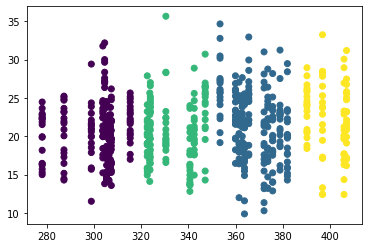

In [72]:
plt.scatter(df.YPG, df.PPG, c=kmeans_off.labels_ )

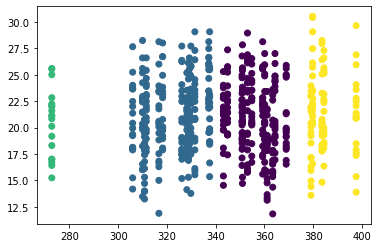

In [73]:
# Plotting defensive measures -- colored by cluster

kmeans_def = KMeans(n_clusters=4, random_state=0).fit(df[['YPG_opp', 'PPG_opp']])
df['labels_kmeans_def'] = kmeans_def.labels_
plt.scatter(df.YPG_opp, df.PPG_opp, c=kmeans_def.labels_)

In [74]:
df.head()

,Tm,W,L,W-L%,PF,PA,PD,MoV,SoS,SRS,...,Yds_opp,Season,PPG,YPG,PPG_opp,YPG_opp,labels_kmeans_off,labels_kmeans_def,labels_ap_off,labels_ap_def
0,Buffalo Bills,11,6,0.647,483,289,194,11.4,-1.6,9.8,...,4637.0,2021,28.411765,381.941176,17.000000,272.764706,1,2,-1,-1
1,New England Patriots,10,7,0.588,462,303,159,9.4,-0.9,8.5,...,5284.0,2021,27.176471,353.411765,17.823529,310.823529,1,1,-1,-1
2,Miami Dolphins,9,8,0.529,341,373,-32,-1.9,-0.8,-2.7,...,5738.0,2021,20.058824,307.000000,21.941176,337.529412,0,1,-1,-1
3,New York Jets,4,13,0.235,310,504,-194,-11.4,1.0,-10.4,...,6760.0,2021,18.235294,306.352941,29.647059,397.647059,0,3,-1,-1
4,Cincinnati Bengals,10,7,0.588,460,376,84,4.9,-1.9,3.1,...,5964.0,2021,27.058824,361.470588,22.117647,350.823529,1,0,-1,-1


In [76]:
f = make_scatter_plot(df)
f.show()

In [75]:
# Plotting defensive performance
f = make_scatter_plot(df, x_label='YPG_opp', y_label='PPG_opp', side_of_ball='def')
f.show()

### Affinity Propagation
Trying out the built-in [Affinity Propagation](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation) module from `scikit-learn`.

In [77]:
from sklearn.cluster import AffinityPropagation

In [78]:
data_off = df[['YPG', 'PPG']]
data_def = df[['YPG_opp', 'PPG_opp']]


ap = AffinityPropagation(verbose=True).fit(data_off)

df['labels_ap_off'] = ap.labels_

Did not converge


/Users/andrewbowen/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



In [79]:
n_clusters = len(np.unique(ap.labels_))

print(f"Affinity Propagation produced {n_clusters}.")

Affinity Propagation produced 1.


Text(0, 0.5, 'PPG')

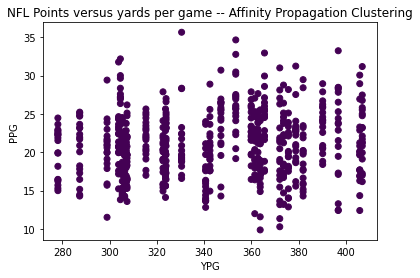

In [80]:
plt.scatter(data_off['YPG'], data_off['PPG'], c=ap.labels_)
plt.title("NFL Points versus yards per game -- Affinity Propagation Clustering")
plt.xlabel("YPG")
plt.ylabel("PPG")

Did not converge


/Users/andrewbowen/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_affinity_propagation.py:226: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



Text(0, 0.5, 'Opp PPG')

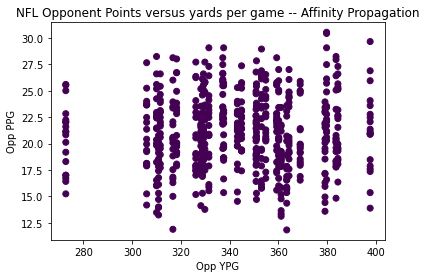

In [81]:
# Doing the same for defensive stats -- opponent YPG and PPG
ap = AffinityPropagation(verbose=True).fit(df[['YPG_opp', 'PPG_opp']])
df['labels_ap_def'] = ap.labels_

plt.scatter(data_def['YPG_opp'], data_def['PPG_opp'], c=ap.labels_)
plt.title("NFL Opponent Points versus yards per game -- Affinity Propagation")
plt.xlabel("Opp YPG")
plt.ylabel("Opp PPG")

### DBSCAN

In [83]:
from sklearn.cluster import DBSCAN

In [89]:
# Run DBSCAN on that jawn
db_off = DBSCAN().fit(df[['YPG', 'PPG']])

df['labels_dbscan_off'] = db_off.labels_

# DBSCAN for Defense
db_def = DBSCAN().fit(df[['YPG_opp', 'PPG_opp']])

df['labels_dbscan_def'] = db_def.labels_

In [91]:
# Plot DBSCAN Offense
f = make_scatter_plot(df, x_label='YPG', y_label="PPG", cluster_type='dbscan')
f

In [93]:
f = make_scatter_plot(df, x_label='YPG_opp', y_label="PPG_opp", side_of_ball='def', cluster_type='dbscan')
f

Looks like DBSCAN is not the algorithm we're looking for :(